In [1]:
import torch
from torch import nn, optim
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms, datasets
import glob
from torchvision import models
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/4995Proj/Project/Data/project_data.zip" "/content/project_data.zip"

In [4]:
!mkdir -p "/content/data"

In [5]:
!unzip -q "/content/project_data.zip" -d "/content/data"

In [6]:
project_data = {}

project_data['spring'] = glob.glob('/content/data/project_data/spring/spring*')
project_data['summer'] = glob.glob('/content/data/project_data/summer/summer*')
project_data['fall'] = glob.glob('/content/data/project_data/fall/fall*')
project_data['winter'] = glob.glob('/content/data/project_data/winter/winter*')

print(f"Spring #:  {len(project_data['spring'])}")
print(f"Summer #:  {len(project_data['summer'])}")
print(f" Fall #:  {len(project_data['fall'])}")
print(f"Winter #:  {len(project_data['winter'])}")

Spring #:  6000
Summer #:  6000
 Fall #:  6000
Winter #:  6000


In [7]:
# Specify data directory
main_dir = '/content/data/project_data'

In [8]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Define the categories (seasons)
categories = ['spring', 'summer', 'fall', 'winter']

# Specify the ratio for splitting
train_ratio = 0.7
val_ratio = 0.15

# Define your transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Empty lists to hold data from each category
train_data = []
val_data = []
test_data = []

In [10]:
# Loop over each category
for i, category in enumerate(categories):
    # Define the full dataset
    full_dataset = datasets.ImageFolder(main_dir, transform=transform)

    # Get the lengths of splits
    train_len = int(train_ratio * len(full_dataset))
    val_len = int(val_ratio * len(full_dataset))
    test_len = len(full_dataset) - train_len - val_len

    # Perform the split
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, lengths=[train_len, val_len, test_len])

    # Add category-specific datasets to the main datasets
    train_data.append(train_dataset)
    val_data.append(val_dataset)
    test_data.append(test_dataset)

In [11]:
# Concatenate all the subsets to create final train, val, and test datasets
train_data = ConcatDataset(train_data)
val_data = ConcatDataset(val_data)
test_data = ConcatDataset(test_data)

# Use DataLoader to convert these datasets into batches, shuffle them, and load in parallel
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [12]:
image, _ = train_data[0]  # get the first image from the dataset
input_image_size = image.shape  # get the shape of the image
input_image_size

torch.Size([3, 224, 224])

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 112 * 112, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 6
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 2

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 6
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 2

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # compute loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        train_acc += calculate_accuracy(outputs, labels)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader)

    # Validation phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # compute loss and accuracy
            val_loss += loss.item() * inputs.size(0)
            val_acc += calculate_accuracy(outputs, labels)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader)

    # Save model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1

    print('Epoch: {}/{}'.format(epoch+1, num_epochs))
    print('Training Loss: {:.4f} - Training Accuracy: {:.4f}'.format(train_loss, train_acc))
    print('Validation Loss: {:.4f} - Validation Accuracy: {:.4f}'.format(val_loss, val_acc))

    # Check for early stopping
    if patience_counter >= patience_limit:
        print('Early stopping triggered')
        break

print('Finished Training')

Epoch: 1/6
Training Loss: 1.1143 - Training Accuracy: 0.5237
Validation Loss: 0.7695 - Validation Accuracy: 0.7226
Epoch: 2/6
Training Loss: 0.6833 - Training Accuracy: 0.7522
Validation Loss: 0.3955 - Validation Accuracy: 0.8892
Epoch: 3/6
Training Loss: 0.4371 - Training Accuracy: 0.8655
Validation Loss: 0.2713 - Validation Accuracy: 0.9305
Epoch: 4/6
Training Loss: 0.3413 - Training Accuracy: 0.9036
Validation Loss: 0.2246 - Validation Accuracy: 0.9403
Epoch: 5/6
Training Loss: 0.2812 - Training Accuracy: 0.9221
Validation Loss: 0.1993 - Validation Accuracy: 0.9448
Epoch: 6/6
Training Loss: 0.2381 - Training Accuracy: 0.9336
Validation Loss: 0.1821 - Validation Accuracy: 0.9481
Finished Training


In [19]:
# Load the best model
model.load_state_dict(torch.load('best_model_CNN.pth'))

# Testing phase
model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # compute loss and accuracy
        test_loss += loss.item() * inputs.size(0)
        test_acc += calculate_accuracy(outputs, labels)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_acc / len(test_loader)

print('Testing Loss: {:.4f} - Testing Accuracy: {:.4f}'.format(test_loss, test_acc))

Testing Loss: 0.1287 - Testing Accuracy: 0.9593


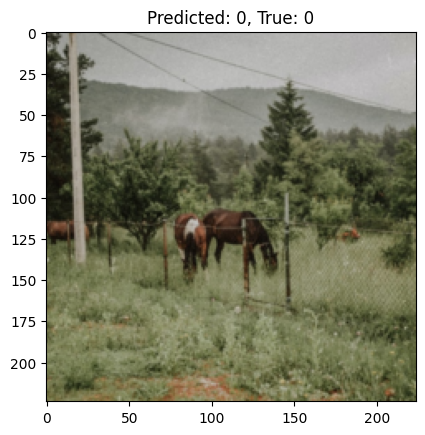

In [34]:
import matplotlib.pyplot as plt
import torch
import numpy as np

model.eval()

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)


def imshow(img, label, pred_label):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f'Predicted: {pred_label}, True: {label}')
    plt.show()

imshow(images[0], labels[0].item(), preds[0].item())